In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ds1 = xr.open_dataset('data/1_po75-25_di5e-8/water.nc')
ds2 = xr.open_dataset('data/2_po75-25_di4e-8/water.nc')
ds3 = xr.open_dataset('data/3_po75-25_di3e-8/water.nc')
ds4 = xr.open_dataset('data/4_po75-25_di2e-8/water.nc')
ds5 = xr.open_dataset('data/5_po75-25_di1e-8/water.nc')
ds6 = xr.open_dataset('data/6_po75-25_di9e-9/water.nc')
ds7 = xr.open_dataset('data/7_po75-25_di8e-9/water.nc')
ds8 = xr.open_dataset('data/11_po75-25_di4e-9/water.nc')
ds9 = xr.open_dataset('data/13_po75-25_di2e-9/water.nc')

In [3]:
alk_year = []
alkflux_bottom_year = []

In [4]:
i = 0
for ds in (ds1, ds2, ds3, ds4, ds5, ds6, ds7, ds8, ds9):
    alk_df = ds['B_C_Alk'].to_dataframe()
    alkflux_df = ds['B_C_Alk   _flux'].to_dataframe()
    alk = alk_df.groupby('z').get_group(0.625)
    alkflux_bottom = alkflux_df.groupby('z_faces').get_group(2.5)
    alk_year.append(alk.loc['2011-01-01':'2011-12-31'])
    alkflux_bottom_year.append(alkflux_bottom.loc['2011-01-01':'2011-12-31'])
    alk_year[i] = alk_year[i].reset_index()
    alkflux_bottom_year[i] = alkflux_bottom_year[i].reset_index()
    alk_year[i]['B_C_Alk'] = alk_year[i]['B_C_Alk']-alk_year[i]['B_C_Alk'].min()
    i += 1

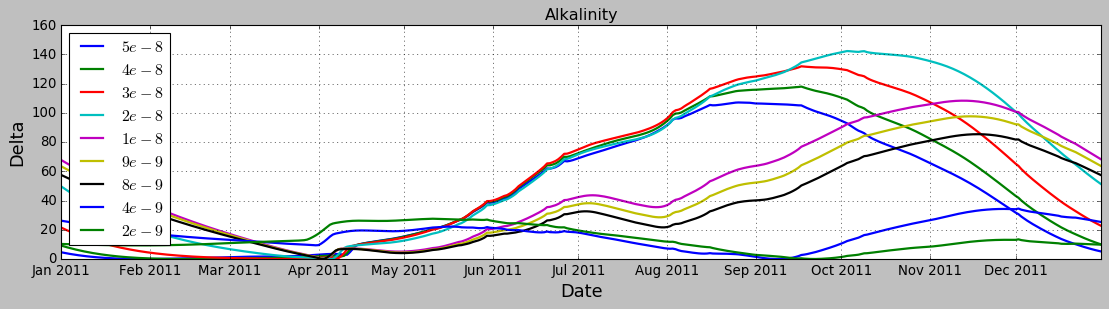

In [5]:
plt.style.use('classic')
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 1, 1) # row-col-num
ax.plot(alk_year[0]['time'], alk_year[0]['B_C_Alk'], linewidth=2, label=r'$5e-8$')
ax.plot(alk_year[1]['time'], alk_year[1]['B_C_Alk'], linewidth=2, label=r'$4e-8$')
ax.plot(alk_year[2]['time'], alk_year[2]['B_C_Alk'], linewidth=2, label=r'$3e-8$')
ax.plot(alk_year[3]['time'], alk_year[3]['B_C_Alk'], linewidth=2, label=r'$2e-8$')
ax.plot(alk_year[4]['time'], alk_year[4]['B_C_Alk'], linewidth=2, label=r'$1e-8$')
ax.plot(alk_year[5]['time'], alk_year[5]['B_C_Alk'], linewidth=2, label=r'$9e-9$')
ax.plot(alk_year[6]['time'], alk_year[6]['B_C_Alk'], linewidth=2, label=r'$8e-9$')
ax.plot(alk_year[7]['time'], alk_year[7]['B_C_Alk'], linewidth=2, label=r'$4e-9$')
ax.plot(alk_year[8]['time'], alk_year[8]['B_C_Alk'], linewidth=2, label=r'$2e-9$')
# --- add title and axis labels
ax.set_title('Alkalinity')
ax.set_ylabel('Delta', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
# --- plot a legend in the best location
ax.legend(loc='best')
# --- add grid – not in default classic style
ax.grid(True)
# --- improve the layout
fig.tight_layout(pad=1)

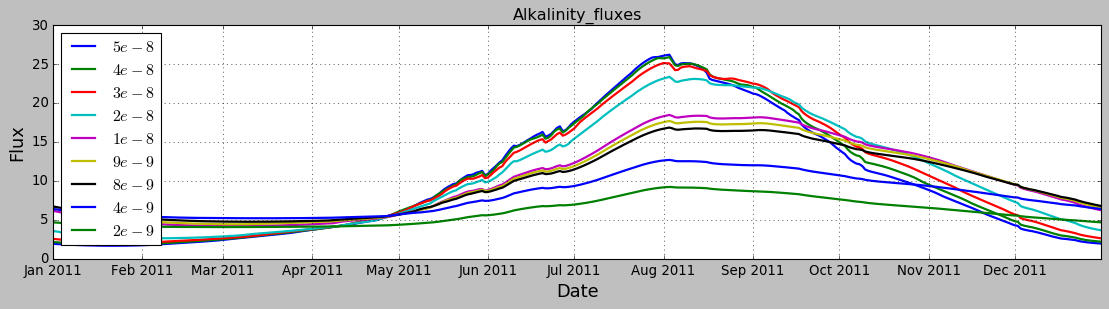

In [6]:
plt.style.use('classic')
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 1, 1) # row-col-num
ax.plot(alkflux_bottom_year[0]['time'], alkflux_bottom_year[0]['B_C_Alk   _flux'], linewidth=2, label=r'$5e-8$')
ax.plot(alkflux_bottom_year[1]['time'], alkflux_bottom_year[1]['B_C_Alk   _flux'], linewidth=2, label=r'$4e-8$')
ax.plot(alkflux_bottom_year[2]['time'], alkflux_bottom_year[2]['B_C_Alk   _flux'], linewidth=2, label=r'$3e-8$')
ax.plot(alkflux_bottom_year[3]['time'], alkflux_bottom_year[3]['B_C_Alk   _flux'], linewidth=2, label=r'$2e-8$')
ax.plot(alkflux_bottom_year[4]['time'], alkflux_bottom_year[4]['B_C_Alk   _flux'], linewidth=2, label=r'$1e-8$')
ax.plot(alkflux_bottom_year[5]['time'], alkflux_bottom_year[5]['B_C_Alk   _flux'], linewidth=2, label=r'$9e-9$')
ax.plot(alkflux_bottom_year[6]['time'], alkflux_bottom_year[6]['B_C_Alk   _flux'], linewidth=2, label=r'$8e-9$')
ax.plot(alkflux_bottom_year[7]['time'], alkflux_bottom_year[7]['B_C_Alk   _flux'], linewidth=2, label=r'$4e-9$')
ax.plot(alkflux_bottom_year[8]['time'], alkflux_bottom_year[8]['B_C_Alk   _flux'], linewidth=2, label=r'$2e-9$')
# --- add title and axis labels
ax.set_title('Alkalinity_fluxes')
ax.set_ylabel('Flux', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
# --- plot a legend in the best location
ax.legend(loc='best')
# --- add grid – not in default classic style
ax.grid(True)
# --- improve the layout
fig.tight_layout(pad=1)